# **Comparing Multiple Models for Fraud Detection**

In this notebook, we compare various machine learning models to identify the best-performing algorithm for fraud detection. The comparison is based on consistent evaluation metrics, including **ROC-AUC**, **GINI Coefficient**, **Confusion Matrix**, **Error Types (Type I and Type II Errors)**, and **Speed Performance** (training and prediction times).

**Models Evaluated:**

- RandomForestClassifier
- LightGBM
- XGBoost
- MLPClassifier
- Logistic Regression


In [39]:
import pandas as pd
import numpy as np

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Utilities
import time
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data

In [3]:
X_train_scaled, y_train, X_valid_scaled, y_valid, X_test_scaled, y_test = joblib.load('preprocessed_data.pkl')

print("Preprocessed data loaded successfully.")

Preprocessed data loaded successfully.


### Handling Class Imbalance

In [12]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE resampling:")
print(f"X_train_smote shape: {X_train_smote.shape}")
print(f"y_train_smote distribution:\n{pd.Series(y_train_smote).value_counts()}")

After SMOTE resampling:
X_train_smote shape: (341176, 30)
y_train_smote distribution:
Class
0    170588
1    170588
Name: count, dtype: int64


### Define Evaluation Metrics and Utility Functions

In [26]:
def evaluate_model(model, model_name, X_train, y_train, X_valid, y_valid, threshold=0.5):
    # Measure training time
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Measure prediction time
    start_pred = time.time()
    valid_probs = model.predict_proba(X_valid)[:, 1]
    valid_preds = (valid_probs >= threshold).astype(int)
    end_pred = time.time()
    pred_time = end_pred - start_pred

    # Calculate ROC-AUC and GINI
    roc_auc = roc_auc_score(y_valid, valid_probs)
    gini = 2 * roc_auc - 1

    # Generate classification report
    report = classification_report(y_valid, valid_preds, target_names=['Not Fraud', 'Fraud'], output_dict=True)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_valid, valid_preds)

    # Print results
    print(f"--- {model_name} ---")
    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Prediction Time: {pred_time:.4f} seconds")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Validation GINI: {gini:.4f}")
    print("Classification Report:")
    print(pd.DataFrame(report))

    # Plot confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix ({model_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Extract metrics of interest
    fraud_metrics = report['Fraud']
    precision = fraud_metrics['precision']
    recall = fraud_metrics['recall']
    f1 = fraud_metrics['f1-score']

    return {
        'Model': model_name,
        'ROC-AUC': roc_auc,
        'GINI': gini,
        'Precision_Fraud': precision,
        'Recall_Fraud': recall,
        'F1_Fraud': f1,
        'Train_Time': train_time,
        'Pred_Time': pred_time
    }


### Initialize and Training of Multiple Models

In [45]:
models = [
    (RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'), "Random Forest"),
    (LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced'), "LightGBM"),
    (XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', scale_pos_weight=1), "XGBoost"),
    (MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42), "MLPClassifier"),
    (LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42), "Logistic Regression")
]


--- Random Forest ---
Training Time: 38.8314 seconds
Prediction Time: 0.0927 seconds
Validation ROC-AUC: 0.9561
Validation GINI: 0.9122
Classification Report:
              Not Fraud      Fraud  accuracy     macro avg  weighted avg
precision      0.999596   0.853933  0.999368      0.926764      0.999342
recall         0.999771   0.767677  0.999368      0.883724      0.999368
f1-score       0.999683   0.808511  0.999368      0.904097      0.999351
support    56863.000000  99.000000  0.999368  56962.000000  56962.000000


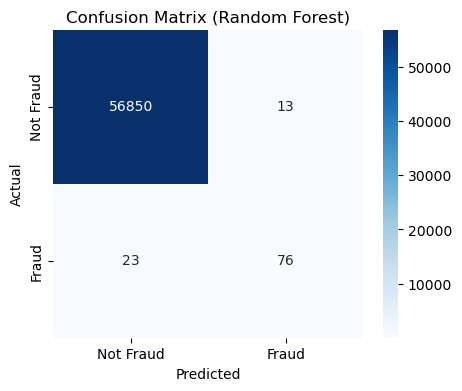

[LightGBM] [Info] Number of positive: 170588, number of negative: 170588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 341176, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- LightGBM ---
Training Time: 2.0167 seconds
Prediction Time: 0.0650 seconds
Validation ROC-AUC: 0.9649
Validation GINI: 0.9297
Classification Report:
              Not Fraud      Fraud  accuracy     macro avg  weighted avg
precision      0.999666   0.606061  0.998754      0.802863      0.998982
recall         0.999086   0.808081  0.998754      0.903583      0.998754
f1-score       0.999376   0.692641  0.998754      0.846008      0.998842
support    56863.000000  99.000000  0.998754  56962.000000  56962.000000


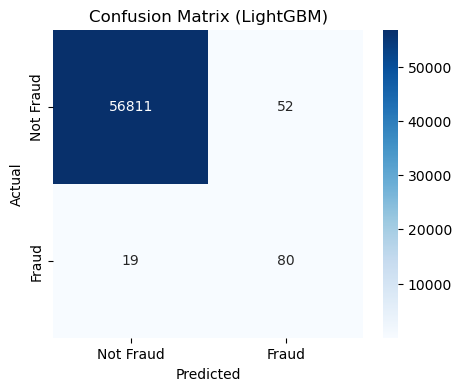

--- XGBoost ---
Training Time: 1.8072 seconds
Prediction Time: 0.0316 seconds
Validation ROC-AUC: 0.9668
Validation GINI: 0.9337
Classification Report:
              Not Fraud      Fraud  accuracy     macro avg  weighted avg
precision      0.999631   0.787879  0.999263      0.893755      0.999263
recall         0.999631   0.787879  0.999263      0.893755      0.999263
f1-score       0.999631   0.787879  0.999263      0.893755      0.999263
support    56863.000000  99.000000  0.999263  56962.000000  56962.000000


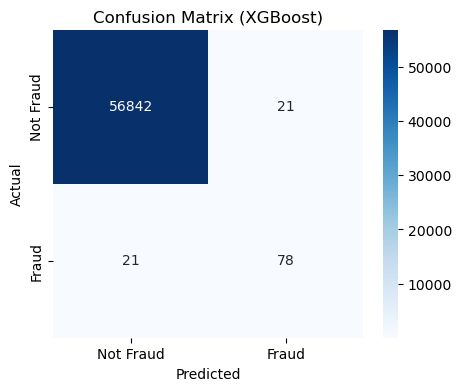

--- MLPClassifier ---
Training Time: 29.4464 seconds
Prediction Time: 0.0362 seconds
Validation ROC-AUC: 0.9440
Validation GINI: 0.8881
Classification Report:
              Not Fraud      Fraud  accuracy     macro avg  weighted avg
precision      0.999437   0.770115  0.999087      0.884776      0.999039
recall         0.999648   0.676768  0.999087      0.838208      0.999087
f1-score       0.999543   0.720430  0.999087      0.859986      0.999058
support    56863.000000  99.000000  0.999087  56962.000000  56962.000000


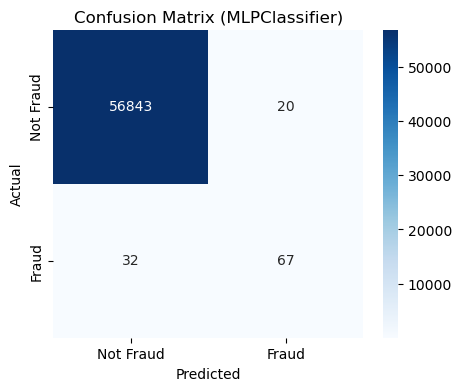

--- Logistic Regression ---
Training Time: 3.3020 seconds
Prediction Time: 0.0055 seconds
Validation ROC-AUC: 0.9718
Validation GINI: 0.9436
Classification Report:
              Not Fraud      Fraud  accuracy     macro avg  weighted avg
precision      0.999783   0.055805  0.973948      0.527794      0.998143
recall         0.974113   0.878788  0.973948      0.926451      0.973948
f1-score       0.986781   0.104946  0.973948      0.545864      0.985249
support    56863.000000  99.000000  0.973948  56962.000000  56962.000000


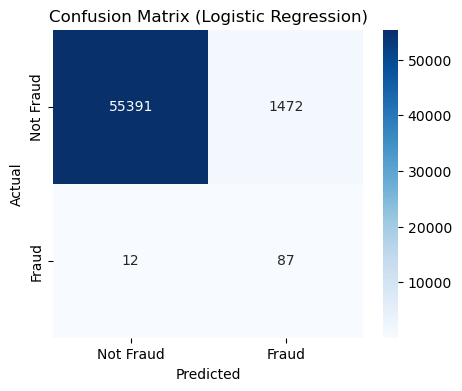

Comparison Results:


,Model,ROC-AUC,GINI,Precision_Fraud,Recall_Fraud,F1_Fraud,Train_Time,Pred_Time
1,Random Forest,0.956124,0.912248,0.853933,0.767677,0.808511,38.831432,0.092712
2,LightGBM,0.964865,0.929731,0.606061,0.808081,0.692641,2.016741,0.064975
3,XGBoost,0.966835,0.933671,0.787879,0.787879,0.787879,1.807214,0.031562
4,MLPClassifier,0.944035,0.888069,0.770115,0.676768,0.720430,29.446424,0.036213
5,Logistic Regression,0.971804,0.943609,0.055805,0.878788,0.104946,3.301972,0.005524


In [46]:
results = []
for model, name in models:
    res = evaluate_model(model, name, X_train_smote, y_train_smote, X_valid_scaled, y_valid, threshold=0.5)
    results.append(res)

results_df = pd.DataFrame(results)
results_df.reset_index(drop=True, inplace=True)
results_df.index += 1 
print("Comparison Results:")
display(results_df)
